# Predicting customers who will "charge-off"

#Define charge-off
Steps:
1. Data Cleaning
2. Feature selection and transformation
3. Build the models
4. Test the models

Before starting: Install the imblearn python package on your computer! 
    
    Run the following in terminal: pip install -U imbalanced-learn

Let's load the libraries, connect to the database, parse dates and load all data in-memory. Make sure the three files database.sqlite, LCDataDictionary.xlsx, and loan.csv are all in the same folder as this notebook.

In [246]:
import sqlite3 #this library manages sql databases
import pandas as pd  #this library enables data manipulation and analysis methods to be used in Python
import numpy as np #this library focuses on scientific computing and using arrays and matrices
%matplotlib inline 
import matplotlib.pyplot as plt #this imports the matplotlib library, along with the interactive plotting pylab module

conn = sqlite3.connect('database.sqlite') # This runs sql within Python; will take a few minutes to run - literally, a few minutes
to_parse = ['issue_d' , 'earliest_cr_line', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d'] #takes a look at the columns, and cuts them up along columns, extracts columns so we can build a Python dataframe
df = pd.read_sql_query('select * from loan', con=conn, parse_dates = to_parse) #pandas feature, read SQL query into dataframe and load in-memory

In [247]:
df.head() #shows the first few rows of the pandas dataframe we created; allows you to see the variables

,index,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599.0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167.0,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524.0,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178.0,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748.0,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [248]:
print('The shape is {}'.format(df.shape)) #tells us no of rows and columns of the df
print('Memory : {} Mb'.format(int(df.memory_usage(deep=False).sum() / 1000000))) #tells us how big the df is in Mb

The shape is (887383, 75)
Memory : 532 Mb


That's a fairly large dataframe! Perhaps we can reduce its size without loss by removing cells with little information. (What does "little information" mean?) This will serve to make the dataframe more manageable.

For this first assignment, we will remove columns whose cells are missing more than 60% of their values. 

## Data Cleaning


### Check which features have good coverage, e.g. more/less than N% missing values

In [249]:
check_null = df.isnull().sum(axis=0).sort_values(ascending=False)/float(len(df))#.isnull() is a pandas feature that checks for missing values
#.sum() is a feature that will sum the previous feature of how many null values, with axis = 0 representing a vertical concatenation, which checks down the column of each dataframe. If axis = 1, this would be a horizontal concatenation checking each row instead of columns
#sort_values will then sort the results, with ascending = False meaning that results will be sorted is a descending order. This is all divided by the length of the dataframe, which has been converted to a float value
check_null[check_null>0.6] #outputs the feature and fraction of missing values

dti_joint                      0.999426
verification_status_joint      0.999424
annual_inc_joint               0.999424
il_util                        0.979020
mths_since_rcnt_il             0.976549
all_util                       0.975916
max_bal_bc                     0.975916
open_rv_24m                    0.975916
open_rv_12m                    0.975916
total_cu_tl                    0.975916
total_bal_il                   0.975916
open_il_24m                    0.975916
open_il_12m                    0.975916
open_il_6m                     0.975916
open_acc_6m                    0.975916
inq_fi                         0.975916
inq_last_12m                   0.975916
desc                           0.857977
mths_since_last_record         0.845554
mths_since_last_major_derog    0.750160
dtype: float64

How many columns have more than 60% missing?

In [250]:
check_null[check_null>0.6].size #.size is a feature that returns how big a series is. Check_null is a series which checks for how many columns have more than 60% of their values missing, meaning that 20 columns have more than 60% of data missing
#check_null is the overall series we are checking, but we must specify [check_null>0.6] to capture that we are looking for specifically parts of the series that have >60% data missing

20

In [251]:
df.head() #shows the first few rows of the pandas dataframe we created; allows you to see the variables. The opposite is tail. You can add a parameter that says how many it shows.

,index,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599.0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167.0,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524.0,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178.0,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748.0,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Checking Features With Little Variation or No Use

A lot of these columns have NaN values, or have little variation. Neither of these will be super useful to us. Let us first look at the columns with little variation, NaN values, and then drop columns we do not need.

1) index
2) policy_code
3) pymnt_plan
4) url
5) id
6) member_id
7) application_type
8) acc_now_delinq
9) emp_title
10) zip_code
11) title

Index is already built into the dataframe, so let us drop it.

#### Exploring Columns with Little Variation

We will now use .groupby to group the dataframe by the specified columns above and sort each column by its values to showcase how much variation these columns have.

In [252]:
#get grouped data
df.groupby('policy_code').size().sort_values()
#.groupby is a pandas feature that will group the dataframe amongst groups designated by mappers or column names
#in this case we want the policy_code data so we will group by inputting the column policy_code to get that data
#.size() will compute the group size
#.sort_values() will then sort the values
#since all values are the same, we get the following: 1.0 value for POlicy_code amongst all 887382 rows

policy_code
1.0    887382
dtype: int64

In [253]:
#check for variation
np.var(df.filter(regex='policy_code'))
#np is numpy
#.var is a numpy feature that will return the variance for the specified elements
#df.filter serves to filter the data we want the variance on
#regex stands for regular expression, which we are inputting as policy_code to specify this is the data we want variance on
#note that variance only works when checking numbers (int/float), not strings

policy_code    0.0
dtype: float64

An output of 0 means there is no variance, which makes sense as policy_code is always = 1.0.

In [254]:
df.groupby('pymnt_plan').size().sort_values()

pymnt_plan
y        10
n    887372
dtype: int64

In [255]:
#Now we are going to try a loop to see if we can catch the number of unique values in this column
#we do a loop instead of the above variance method as variance only works on numbers, and this column has string values of "yes" or "no"
unique = [] #set an empty list
for x in df.groupby('pymnt_plan').size().sort_values(): #create a for loop, saying that for each value in the payment plan column
    if x not in unique: #for each of those values, if they are not in the unique list
        unique.append(x) #append/add the value to the list
print(len(unique)) #after the loop ends, print out the length of the unique list, which effectively gives us the number of unique values

2


Only 2 different values. For pymnt_plan, only 10 rows take the value "yes", which means there is little useful variation. URL, ID doesn't seem to have any useful information.

In [256]:
df.groupby('application_type').size().sort_values()

application_type
JOINT            511
INDIVIDUAL    886871
dtype: int64

A majority of the applications are indiviudal, with few joint. The little variation here does not help or contribute to our analysis, so this will also be removed. (Alternatively, we could separately analyze the data sets, or just analyze individual applications. Try this at home?)

In [257]:
df.groupby('acc_now_delinq').size().sort_values() # for now, we don't use that variable, but perhaps we can use it in the future?

acc_now_delinq
6.0          1
14.0         1
5.0          3
4.0          7
3.0         28
2.0        208
1.0       3866
0.0     883239
dtype: int64

In [258]:
np.var(df.filter(regex='acc_now_delinq'))

acc_now_delinq    0.006026
dtype: float64

The variance is quite low, meaning that the values are close to each other. Also notice the majority of values are concentrated at 0.0

In [259]:
df.groupby('emp_title').size().sort_values() # for now, we don't use that variable, but perhaps we can use it in the future?

emp_title
 \tAdv Mtr Proj Fld Rep                         1
Risk Systems Analyst                            1
Risk advisory supervisor                        1
Risk analysis                                   1
Risk and Control Analyst II                     1
Risk and Safety Management                      1
Risk consultant                                 1
Risk control                                    1
Risk coordinator                                1
Risk director                                   1
Risk enterprise management                      1
Risk management advisor                         1
Risk management assistant                       1
Risk officer                                    1
Risk System Analyst                             1
Risk services manager                           1
Risk/Control Officer                            1
RiskMetrics Group                               1
Risks and Controls Sr Analyst                   1
Risnychok & Associates, Inc.            

In [260]:
unique = []
for x in df.groupby('emp_title').size().sort_values():
    if x not in unique:
        unique.append(x)
print(len(unique))

456


So there are a lot of different professions here. Perhaps we can use that later.

In [261]:
df.groupby('zip_code').size().sort_values() # for now, we don't use that variable, but perhaps we can use it in the future?

zip_code
649xx       1
643xx       1
862xx       1
621xx       1
817xx       1
849xx       1
819xx       1
507xx       1
509xx       1
682xx       1
511xx       1
513xx       1
514xx       1
516xx       1
520xx       1
569xx       1
568xx       1
429xx       1
524xx       1
889xx       1
694xx       1
892xx       1
399xx       1
375xx       1
901xx       1
909xx       1
742xx       1
205xx       1
938xx       1
888xx       1
         ... 
920xx    4303
956xx    4329
600xx    4518
604xx    4527
021xx    4532
080xx    4539
601xx    4603
481xx    4645
334xx    4744
113xx    4813
925xx    4907
913xx    5161
926xx    5415
852xx    5442
921xx    5661
104xx    6008
117xx    6129
330xx    6283
917xx    6357
891xx    6441
770xx    6938
900xx    7287
331xx    7416
070xx    7431
100xx    7609
300xx    8126
606xx    8641
112xx    9272
750xx    9417
945xx    9770
Length: 935, dtype: int64

In [262]:
unique = []
for x in df.groupby('zip_code').size().sort_values():
    if x not in unique:
        unique.append(x)
print(len(unique))

695


In [263]:
df.groupby('title').size().sort_values() #You could try and check whether people who know how to spell English words are less likely to default

title
Ã®ÂÂÃ®ÂÂMY FIRST CAR Ã®ÂÂÃ®ÂÂ            1
PB&J Wedding                                     1
PCS Simplification                               1
PEACE  OF  MIND                                  1
lower rate for debt consolidation                1
lower rate credit card payoff                    1
lower rate 78                                    1
PEACE of mind                                    1
PEICE OF MIND                                    1
PEPE LOAN                                        1
PERFECTONE                                       1
PAyoff                                           1
PEROSNAL                                         1
lower payments/debt                              1
PERSONAL BILL CONSOLIDATE                        1
PERSONAL BUSINESS                                1
PERSONAL CONSOLIDATE                             1
PERSONAL CONSOLIDATION                           1
PERSONAL CREDIT                                  1
PERSONAL DEBT CONSOLIDATI

In [264]:
unique = []
for x in df.groupby('title').size().sort_values():
    if x not in unique:
        unique.append(x)
print(len(unique))

238


Now that we have gone through the data for the above columns, we can now delete them and columns lacking value:

In [265]:
df.dropna(axis = 1, how = 'all') #vertical concatenation, ensure only dropping columns who have ALL NaN values


,index,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599.0,5000.0,5000.0,4975.000000,36 months,10.65%,162.87,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167.0,2500.0,2500.0,2500.000000,60 months,15.27%,59.83,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524.0,2400.0,2400.0,2400.000000,36 months,15.96%,84.33,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178.0,10000.0,10000.0,10000.000000,36 months,13.49%,339.31,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748.0,3000.0,3000.0,3000.000000,60 months,12.69%,67.79,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,1075269,1311441.0,5000.0,5000.0,5000.000000,36 months,7.90%,156.46,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,1069639,1304742.0,7000.0,7000.0,7000.000000,60 months,15.96%,170.08,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,1072053,1288686.0,3000.0,3000.0,3000.000000,36 months,18.64%,109.43,E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,1071795,1306957.0,5600.0,5600.0,5600.000000,60 months,21.28%,152.39,F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,1071570,1306721.0,5375.0,5375.0,5350.000000,60 months,12.69%,121.45,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


To check this worked, let us list the columns now

In [266]:
df.columns        

Index(['index', 'id', 'member_id', 'loan_amnt', 'funded_amnt',
       'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade',
       'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url',
       'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint',
       'verification_sta

Now to specifically remove columns we just checked with little variation or data that does not apply to us right now. 

In [267]:
delete_me = ['index', 'policy_code', 'pymnt_plan', 'url', 'id', 'member_id', 'application_type', 'acc_now_delinq','emp_title', 'zip_code','title']
#created a list of columns we want to delete
df.drop(delete_me , axis=1, inplace=True) 
#using the drop feature in pandas to drop the specified items in delete me, through a vertical concatenation to make sure we are specifying we want to delete columns
#inplace = True means that the data is renamed in place (it returns nothing), instead of creating a copy, which would happen if inplace = False

Let's check the columns again!

In [268]:
df.columns #load columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'desc',
       'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'annual_inc_joint', 'dti_joint', 'verification_status_joint',
       'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_il_6m',
       'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', '

Excellent! Now, let's check the basic stats for each column.

In [269]:
df.describe() #get basic stats of each column in table now

,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
count,887382.000000,887382.000000,887382.000000,887382.000000,8.873780e+05,887382.00000,887353.000000,887353.000000,433069.000000,137053.000000,...,21372.000000,18617.000000,21372.000000,21372.000000,21372.000000,21372.000000,8.171060e+05,21372.000000,21372.000000,21372.000000
mean,14755.280082,14741.893147,14702.480039,436.717647,7.502761e+04,18.15702,0.314445,0.694622,34.063697,70.117903,...,36552.811389,71.535317,1.389060,2.975482,5887.979740,60.831939,3.206868e+04,0.943945,1.537058,1.977307
std,8435.456408,8429.898507,8442.107612,244.186619,6.469823e+04,17.19060,0.862247,0.998447,21.884941,28.127914,...,43103.833619,23.022862,1.520129,2.631886,5284.701239,20.013254,3.749833e+04,1.446872,2.723339,2.874067
min,500.000000,500.000000,0.000000,15.670000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,-4.000000
25%,8000.000000,8000.000000,8000.000000,260.710000,4.500000e+04,11.91000,0.000000,0.000000,15.000000,51.000000,...,10251.500000,58.600000,0.000000,1.000000,2411.000000,47.700000,1.390000e+04,0.000000,0.000000,0.000000
50%,13000.000000,13000.000000,13000.000000,382.550000,6.500000e+04,17.65000,0.000000,0.000000,31.000000,70.000000,...,24684.500000,74.900000,1.000000,2.000000,4483.000000,61.900000,2.370000e+04,0.000000,0.000000,2.000000
75%,20000.000000,20000.000000,20000.000000,572.600000,9.000000e+04,23.95000,0.000000,1.000000,50.000000,92.000000,...,47858.000000,87.600000,2.000000,4.000000,7771.500000,75.200000,3.980000e+04,1.000000,2.000000,3.000000
max,35000.000000,35000.000000,35000.000000,1445.460000,9.500000e+06,9999.00000,39.000000,33.000000,188.000000,129.000000,...,878459.000000,223.300000,22.000000,43.000000,127305.000000,151.400000,9.999999e+06,17.000000,35.000000,32.000000


Now, let's check the type of each column.

In [270]:
df.dtypes #check types

loan_amnt                             float64
funded_amnt                           float64
funded_amnt_inv                       float64
term                                   object
int_rate                               object
installment                           float64
grade                                  object
sub_grade                              object
emp_length                             object
home_ownership                         object
annual_inc                            float64
verification_status                    object
issue_d                        datetime64[ns]
loan_status                            object
desc                                   object
purpose                                object
addr_state                             object
dti                                   float64
delinq_2yrs                           float64
earliest_cr_line               datetime64[ns]
inq_last_6mths                        float64
mths_since_last_delinq            

As we can see, there are a variety of data types. Let's clean that up and convert specifcally the datetime64[ns] type into something we can better use.

## Feature transformations


We need to transform a few metrics which sound very important, but are formatted as strings. These transformations are performed with the data modelling in mind. Ultimatelly we want to produce a dataset almost ready to be fed to the model. Here is a summary of the operations performed:

1) Strip months from term and make it an integer
2) The Interest rate is a string. Remove % and make it a float
3) Extract numbers from emp_length and fill missing values with the median. If emp_length == 10+ years then leave it as 10
4) Transform datetimes to a Period (class in Pandas)

In [271]:
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,10+ years,RENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,< 1 year,RENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,10+ years,RENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,10+ years,RENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,1 year,RENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [272]:
#1. Strip `months` from `term` e.g. "36 month" to "36"
df['term'] = df['term'].str.split(' ').str[1] #str = string
#breaking term values by space, turning [36 months] into [36, months]
#Can anyone figure out why the index is 1 instead of 0? 

In [273]:
#interest rate is a string. Remove % and make it a float. 
df['int_rate'] = df['int_rate'].str.split('%').str[0]
#break int_rate terms by %, turning [10.65%] into [10.65]
df['int_rate'] = df.int_rate.astype(float)/100.
#making it so that int_rate is now assigned type float
#divide by 100 to convert to decimal and ensure proper value since % was removed

In [274]:
df.head() #success

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,5000.0,5000.0,4975.0,36,0.1065,162.87,B,B2,10+ years,RENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2500.0,2500.0,2500.0,60,0.1527,59.83,C,C4,< 1 year,RENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2400.0,2400.0,2400.0,36,0.1596,84.33,C,C5,10+ years,RENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10000.0,10000.0,10000.0,36,0.1349,339.31,C,C1,10+ years,RENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3000.0,3000.0,3000.0,60,0.1269,67.79,B,B5,1 year,RENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Extract numbers from emp_length and fill missing values with the median.

In [275]:
df['emp_length'] = df['emp_length'].str.extract('(\d+)').astype(float)
#\d+ extracts the integer
#emp_length is probably important for modelling defaul, so I don't want to drop it, but instead fill in missing values. But that could be wrong. I'm making up data, after all. Check later?
df['emp_length'] = df['emp_length'].fillna(df.emp_length.median())
#assigning median values to fill missing values, done by .fillna feature


Change the format of the datetime

In [276]:
col_dates = df.dtypes[df.dtypes == 'datetime64[ns]'].index
#selecting all values in dataframe whose datatype is equal to datetimes, assigning to col_dates
for d in col_dates:
    df[d] = df[d].dt.to_period('M')
#creating for loop where for all dates in col_dates, the datatype will be converted to period
#Periods are a class in Python that represent periods of time, and are much easier to manipulate than the current format
#'M' input for to_period stands for months, since that is the time period we are dealing with

In [277]:
df.head() #reload dataframe

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,5000.0,5000.0,4975.0,36,0.1065,162.87,B,B2,10.0,RENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2500.0,2500.0,2500.0,60,0.1527,59.83,C,C4,1.0,RENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2400.0,2400.0,2400.0,36,0.1596,84.33,C,C5,10.0,RENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10000.0,10000.0,10000.0,36,0.1349,339.31,C,C1,10.0,RENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3000.0,3000.0,3000.0,60,0.1269,67.79,B,B5,1.0,RENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now, to check the types of the dataframe to make sure things worked

In [278]:
df.dtypes

loan_amnt                      float64
funded_amnt                    float64
funded_amnt_inv                float64
term                            object
int_rate                       float64
installment                    float64
grade                           object
sub_grade                       object
emp_length                     float64
home_ownership                  object
annual_inc                     float64
verification_status             object
issue_d                         object
loan_status                     object
desc                            object
purpose                         object
addr_state                      object
dti                            float64
delinq_2yrs                    float64
earliest_cr_line                object
inq_last_6mths                 float64
mths_since_last_delinq         float64
mths_since_last_record         float64
open_acc                       float64
pub_rec                        float64
revol_bal                

Now we can move onto the modelling!

# Data Modelling

Let's build a model which predicts the status charged_off. (Which question does that answer? Are you perhaps also interested in answering different questions?) Let's first check which fraction of the observations is charged off.

In [279]:
loan_status_grouped = df.groupby('loan_status').size().sort_values(ascending=False)/len(df) * 100
#checking each loan status by pulling the column of statuses and sorting from high to low commonality
#divide by length of data frame in end to figure out percentage of total dataframe that is status
#multiply by 100 since percentages (since there is no % sign)
loan_status_grouped
#show status breakdown

loan_status
Current                                                67.815250
Fully Paid                                             23.408607
Charged Off                                             5.099038
Late (31-120 days)                                      1.306200
Issued                                                  0.953365
In Grace Period                                         0.704656
Late (16-30 days)                                       0.265612
Does not meet the credit policy. Status:Fully Paid      0.224030
Default                                                 0.137370
Does not meet the credit policy. Status:Charged Off     0.085758
dtype: float64

Now we can think of constructing features that are transformation of existing features. (E.g. remember: if you use linear models, you may want to construct variables that allow linear models to fit non-linear relationships along a particular dimension. Think y = x^2.)

* Let's keep the loan_amount, but let's create a metric which indicates that the total amount committed by investors for that loan at that point in time (funded_amnt_inv) is less than what the borrower requested. Perhaps that indicates that other investors aren't super comfortable with the repayment ability?

In [280]:
df['amt_difference'] = 'eq' #set equal as the default value for amt_difference
df.loc[(df['funded_amnt'] - df['funded_amnt_inv']) > 0,'amt_difference'] = 'less'
#replaces the value equal with less in case the funded amount is less than requested
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,amt_difference
0,5000.0,5000.0,4975.0,36,0.1065,162.87,B,B2,10.0,RENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,less
1,2500.0,2500.0,2500.0,60,0.1527,59.83,C,C4,1.0,RENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,eq
2,2400.0,2400.0,2400.0,36,0.1596,84.33,C,C5,10.0,RENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,eq
3,10000.0,10000.0,10000.0,36,0.1349,339.31,C,C1,10.0,RENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,eq
4,3000.0,3000.0,3000.0,60,0.1269,67.79,B,B5,1.0,RENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,eq



* the metrics `delinq_2yrs` has 80% zeros. Let's make it categorical: `no` when `delinq_2yrs == 0` and `yes` when  `delinq_2yrs > 0`

* Same as above for `inq_last_6mths`: The number of inquiries in past 6 months (excluding auto and mortgage inquiries)

* Same as above for `pub_rec`: let's make the number of derogatory public records a binary. (You may play with that and see if we lose information.)

In [281]:
# Turn some continuous variables into binaries

df['delinq_2yrs_cat'] = 'no'
df.loc[df['delinq_2yrs']> 0,'delinq_2yrs_cat'] = 'yes'
#.loc access a group of rows and columns by label(s) or a boolean/conditional lookup, which is why it is being used here
#label used is the dataframe for delinq, if greater than 0 assigning those values yes
#.loc lets us scour this data and insert yes when the boolean condition demands it

df['inq_last_6mths_cat'] = 'no'
df.loc[df['inq_last_6mths']> 0,'inq_last_6mths_cat'] = 'yes'
#same idea as above

df['pub_rec_cat'] = 'no'
df.loc[df['pub_rec']> 0,'pub_rec_cat'] = 'yes'
#same idea as above

#creating a binary variable comparing person's income to state average income
df['higher_than_state_mean_inc'] = 'no'
#creating a dictionary where each state is a key and the median income is the value
addr_state_grouped = df.groupby('addr_state').size().sort_values(ascending=False)

unique = []
#will capture means for each state as values for the dictionary
income_mean = {}
#if no value present, fill with median value
df['annual_inc'] = df['annual_inc'].fillna(df.annual_inc.median())
#if no state present (true in only two cases), assign it to NY (arbritray designation)
df['addr_state'] = df['addr_state'].fillna('NY')

#cycles through each state in the dataset
for x in addr_state_grouped.index:
    if x not in unique:
        unique.append(x)
        #stores income values of every person and categorizes by state into an array
        incomes = df.loc[df['addr_state'] == x, ['annual_inc']].values
        #assigns key value (name of state) to the average of all incomes from a certain state
        income_mean[x] = np.mean(incomes)
#iterates through each person in dataset and compares income values to state mean
for count,x in enumerate(df.addr_state):
    person_inc = df.at[count,'annual_inc']
    #average income for particular state
    state_mean = income_mean[x]
    if (person_inc > state_mean):
        df.at[count,'higher_than_state_mean_inc'] = 'yes'
    
# Create new metric: which fraction of total credit lines is the borrower currently able to still borrow from?
df['acc_ratio'] = df.open_acc / df.total_acc

#new ratio takes open accounts and divides by total accounts to find fraction of total that are open

These are the features we want to use as predictors of charge-off

In [282]:
features = ['loan_amnt','amt_difference', 'term', 'higher_than_state_mean_inc',
            'installment', 'grade','emp_length', 'purpose', 'int_rate',
            'home_ownership', 'annual_inc','verification_status',
             'dti', 'delinq_2yrs_cat', 'inq_last_6mths_cat', 
            'open_acc', 'pub_rec', 'pub_rec_cat', 'acc_ratio', 'initial_list_status',  
            'loan_status'
           ]
#creating list of features

We want to distinguish between a customer who will *charge off* and a customer who will pay in full. For this iteration of this exercise, we remove borrowers who are current. But that limits our sample in interesting ways. We will reconsider this step in the future.

In [283]:
X_clean = df.loc[df.loan_status != 'Current', features] #features is at end to specify which columns we are specifically interested in looking through and using in X_clean dataframe
#the cleaned dataframe is one that has it where the loan status is not equal to current
#again, using loc as it lets us access rows and columns by label(s) or a boolean/conditional lookup
X_clean.head() #get overview of new dataframe that is prepped for modelling

,loan_amnt,amt_difference,term,higher_than_state_mean_inc,installment,grade,emp_length,purpose,int_rate,home_ownership,...,verification_status,dti,delinq_2yrs_cat,inq_last_6mths_cat,open_acc,pub_rec,pub_rec_cat,acc_ratio,initial_list_status,loan_status
0,5000.0,less,36,no,162.87,B,10.0,credit_card,0.1065,RENT,...,Verified,27.65,no,yes,3.0,0.0,no,0.333333,f,Fully Paid
1,2500.0,eq,60,no,59.83,C,1.0,car,0.1527,RENT,...,Source Verified,1.00,no,yes,3.0,0.0,no,0.750000,f,Charged Off
2,2400.0,eq,36,no,84.33,C,10.0,small_business,0.1596,RENT,...,Not Verified,8.72,no,yes,2.0,0.0,no,0.200000,f,Fully Paid
3,10000.0,eq,36,no,339.31,C,10.0,other,0.1349,RENT,...,Source Verified,20.00,no,yes,10.0,0.0,no,0.270270,f,Fully Paid
5,5000.0,eq,36,no,156.46,A,3.0,wedding,0.0790,RENT,...,Source Verified,11.20,no,yes,9.0,0.0,no,0.750000,f,Fully Paid


In [284]:
mask = (X_clean.loan_status == 'Charged Off')  # == is a python operator that checks if two values are equal to each other or not
#if they are, it returns True, and False if not
#this line creates a boolean condition, where mask = True if the loan status is 'Charged Off', and mask = false if not 
X_clean['target'] = 0
#this creates a new column called 'target', which stands for the target variable and end product we are trying to predict
#sets target to 0 for all values
X_clean.loc[mask,'target'] = 1
#this uses .loc method to access cleaned dataframe with mask and 'target arguments', meaning that if mask is true, to set target for that specific data point in the column equal to one
#this is important as this essentially gives us a clear way to point out which data points we are interested in
#as mask is reflecting which loan statuses are charged off or not, and helping to assign charged off points a value of 1 with the latest line of code

## A few last touches
We may want to transform categorical variables in continuous variables using the One Hot Encoder. `pandas` has a built-in function for this.

Clarification: One hot encoding is a method that converts categorical variables into binary vectors that can be utilized by Machine Learning algorithms to do a better job with predictions.

The categorical value represents the numerical value of the entry in the dataset.

We use one hot encoder to perform “binarization” of the category and include it as a feature to train the model.

In [285]:
cat_features = ['term','amt_difference', 'grade', 'home_ownership', 'verification_status','purpose','higher_than_state_mean_inc','delinq_2yrs_cat', 'inq_last_6mths_cat', 'pub_rec_cat', 'initial_list_status']
#make a list of the categorical variables we want to transform using one hot encoder

X_clean.dropna(axis=0, how = 'any', inplace = True)
# Drop any residual missing values, as this will tamper with one hot encoder

X = pd.get_dummies(X_clean[X_clean.columns[:-2]], columns=cat_features).astype(float) #setting x values #FIGURE OUT
#Convert categorical variable into dummy/indicator variables using get_dummies
#X_clean[X_clean.columns[:-2]] = specify the dataframe wwe are using, X_CLean, specify using all columns except the last two (initial_list_status and loan_status)
#Do you know why we are not including these two columns?
#Columns = cat_features specifies which columns in the DataFrame to be encoded. If columns is None then all the columns with object or category dtype will be converted.
#encode as type float
y = X_clean['target'] 
#assign the target values from dataframe to y

In [286]:
print(y) #check values for y, see it contains all values for target, which are either 0 or 1 and represent if specific row is charged off or not

0         0
1         1
2         0
3         0
5         0
7         0
8         1
9         1
10        0
11        0
12        1
13        0
14        1
15        0
16        0
17        0
18        0
19        0
20        0
21        1
22        0
23        0
24        1
25        0
26        1
27        1
28        0
29        0
30        0
31        0
         ..
887202    0
887206    0
887219    0
887235    0
887252    0
887253    0
887258    1
887262    0
887267    0
887268    0
887272    1
887279    1
887280    0
887283    0
887284    0
887294    1
887307    1
887312    1
887326    0
887334    1
887336    0
887341    0
887349    0
887350    0
887351    0
887355    1
887368    0
887370    0
887373    0
887375    1
Name: target, Length: 285572, dtype: int64


## The models

Let's start modelling by importing a few libraries. We must also make sure to standardize all the features and data we are using for the models, in order to reduce quality distillation of our models.

We are importing several modules from sklearn and imblearn which are useful for modelling and analysis.

Regarding scaling, note that many estimators are designed with the assumption that each feature takes values close to zero or more importantly that all features vary on comparable scales. In particular, metric-based estimators often assume approximately standardized data (centered features with unit variances). A notable exception are decision tree-based estimators that are robust to arbitrary scaling of the data.

In [287]:
from sklearn.linear_model import LogisticRegression #Imports logistic regression feature for analysis
from sklearn.model_selection import train_test_split #Imports train testing split, which split arrays or matrices into random train and test subsets
#chooses a random subset (a specified fraction) of X and y as a training sample, uses the remainder as a test sample. random_state sets the initial value.
from sklearn.model_selection import cross_val_score # Allows us to evaluate data by cross-validation
#Learning the parameters of a prediction function and testing it on the same data is a methodological mistake: 
#a model that would just repeat the labels of the samples that it has just seen would have a perfect score but 
#would fail to predict anything useful on yet-unseen data. This situation is called overfitting. 
#To avoid it, it is common practice when performing a (supervised) machine learning experiment to 
#hold out part of the available data as a test set X_test, y_test. 
from sklearn import metrics #The sklearn.metrics module includes score functions, performance metrics 
#and pairwise metrics and distance computations.
from sklearn import preprocessing #The sklearn.preprocessing package provides several common utility 
#functions and transformer classes to change raw feature vectors into a representation that is more 
#suitable for the downstream estimators.
from sklearn.ensemble import RandomForestClassifier #import random forest classifier to use random forest
from imblearn.over_sampling import SMOTE #Import SMOTE feature, explained below

X_scaled = preprocessing.scale(X) #standardize data set along x axis and scale properly
print(X_scaled)
print('   ')
print(X_scaled.shape) #dimensions

[[-1.06342482 -1.05092656  1.19312049 ... -0.38225728  0.67045937
  -0.67045937]
 [-1.36792459 -1.46919029 -1.43222345 ... -0.38225728  0.67045937
  -0.67045937]
 [-1.38010458 -1.369739    1.19312049 ... -0.38225728  0.67045937
  -0.67045937]
 ...
 [-0.91421993 -0.81752047 -1.14051857 ... -0.38225728  0.67045937
  -0.67045937]
 [-1.18522473 -1.19819566  1.19312049 ...  2.61603913  0.67045937
  -0.67045937]
 [-0.35089537 -0.09225668  0.02630096 ... -0.38225728  0.67045937
  -0.67045937]]
   
(285572, 53)


Standardization of datasets is a common requirement for many machine learning estimators implemented in scikit-learn; they might behave badly if the individual features do not more or less look like standard normally distributed data: Gaussian with zero mean and unit variance.

In practice we often ignore the shape of the distribution and just transform the data to center it by removing the mean value of each feature, then scale it by dividing non-constant features by their standard deviation.

For instance, many elements used in the objective function of a learning algorithm (such as the RBF kernel of Support Vector Machines or the l1 and l2 regularizers of linear models) assume that all features are centered around zero and have variance in the same order. If a feature has a variance that is orders of magnitude larger than others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected.

The function scale we use above provides a quick and easy way to perform this operation on array-like datasets.

We will now run two models: Logistic Regression and Random Forest.

Through these models we will make predictions and model the roc curve of the estimators. 

In [288]:
def run_models(X_train, y_train, X_test, y_test, model_type = 'Non-balanced'): #run_models is used below to run them
    #define the funciton run models, with the parameters:
    #X_train: training data set
    #Y_train: set of labels to all the data in x_train
    #The training set is a subset of the data set used to train a model.
    #X_test: test data set
    #y_test:  set of labels to all the data in x_test
    #model_type: specify the type of model we want to use
    #we select non-balanced for now, just to see how the initial model will fare
    
    clfs = {
            'LogisticRegression' : LogisticRegression(),
            'RandomForestClassifier': RandomForestClassifier(n_estimators=10) #n_estimators sets the number of trees in forest for model
            }
    cols = ['model','matthews_corrcoef', 'roc_auc_score', 'precision_score', 'recall_score','f1_score']

    #Establish which methods we want to use - Logistic Regression and Random Forest - with the clfs line that creates a dictionary
    #of the two
    #cols establishes a list of the specific columns of metrics we want
    
    models_report = pd.DataFrame(columns = cols) #this is used to generate an empty model report
    conf_matrix = dict() #create a dictionary for the confidence matrix that assigns the confidence values to specific keys

    for clf, clf_name in zip(clfs.values(), clfs.keys()): 
        #establish a for loop saying that for each method name and value,

        clf.fit(X_train, y_train)
        #Train the model by fitting it to data, using the training data set as inputs
        
        y_pred = clf.predict(X_test) #the predicted labels that will be returned from 
        #.predict, which predicts target values of X given a model
        y_score = clf.predict_proba(X_test)[:,1] #the Target scores, 
        #can either be probability estimates of the positive class, confidence values, 
        #or non-thresholded measure of decisions (as returned by “decision_function” on some classifiers).
        #obtained using .predict_proba, which is a
        #method of a (soft) classifier outputting the probability of the instance being in each of the classes.
        
        print('computing {} - {} '.format(clf_name, model_type)) #print output saying that the file is computing
        #specific model, which is why.format is used at end to pull name and model type to plug into statement

        tmp = pd.Series({'model_type': model_type,
                         'model': clf_name,
                         'roc_auc_score' : metrics.roc_auc_score(y_test, y_score),
                         'matthews_corrcoef': metrics.matthews_corrcoef(y_test, y_pred),
                         'precision_score': metrics.precision_score(y_test, y_pred),
                         'recall_score': metrics.recall_score(y_test, y_pred),
                         'f1_score': metrics.f1_score(y_test, y_pred)})
        #create a dictionary of series names and keys assigning values for what each item is
        #the keys are the desired items we want in the end for our model analysis, with the values
        #explaining how each key is assigned/calculated 
        
        models_report = models_report.append(tmp, ignore_index = True)
        #append the tmp values to our currently empty model report
        #ignore_index = True means we ignore and do not use the index labels, do this as the report needs to show
        #only the names, not the methods for how each item is analyzed
        conf_matrix[clf_name] = pd.crosstab(y_test, y_pred, rownames=['True'], colnames= ['Predicted'], margins=False)
        #establish the confidence matrix, crosstab Compute a simple cross-tabulation of two (or more) factors.
        #Cross tabulation is a tool that allows you compare the relationship between two or more factors.
        #Can you tell what factors are we cross tabulating?
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score, drop_intermediate = False, pos_label = 1)
        #the returns of the ROC curve, all three are arrays 
        #hence use of metrics.roc_curve, uses y test data and target scores to determine three return values
        plt.figure(1, figsize=(6,6))
        plt.xlabel('false positive rate')
        plt.ylabel('true positive rate')
        plt.title('ROC curve - {}'.format(model_type))
        plt.plot(fpr, tpr, label = clf_name )
        plt.legend(loc=2, prop={'size':11})
    plt.plot([0,1],[0,1], color = 'black')
        #plotting dimensions and specifics for the result graph
    
    return models_report, conf_matrix
    #after running function, also give us models_report and confidence matrix for methods

### Model with unbalanced classes
If we do not modify the class ratios our model has very poor predictive power. The area ander the curve (AUC) is about 0.6, suggesting that we perform better than random. However, the recall is zero: we cannot predict the target variable at all. This might be either because there is something wrong with the metrics or because the classes are too unbalanced. 

computing LogisticRegression - Non-balanced 
computing RandomForestClassifier - Non-balanced 


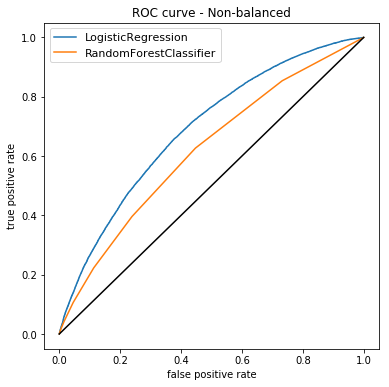

In [289]:
#mpl.rc("savefig", dpi=300)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y.values, test_size=0.4, random_state=0)
#feed training and testing data into train_test_split
#test size is 40%, making training set 60%
#If int, random_state is the seed used by the random number generator;
#A random seed (or seed state, or just seed) is a number (or vector) 
#used to initialize a pseudorandom number generator and set initial value 
#random_state is 0

models_report, conf_matrix = run_models(X_train, y_train, X_test, y_test, model_type = 'Non-balanced')
#now focus on models report and confidence matrix
#run models using data set and non balanced, outputs will be assigned to output report and matrix

What does this graph mean? 

In [290]:
models_report #now to get a report of the models

,model,matthews_corrcoef,roc_auc_score,precision_score,recall_score,f1_score,model_type
0,LogisticRegression,0.028051,0.690154,0.437908,0.003705,0.007348,Non-balanced
1,RandomForestClassifier,0.069579,0.618366,0.336408,0.042358,0.075242,Non-balanced


In [291]:
conf_matrix['LogisticRegression'] #the confidence matrix for logistic regression

Predicted,0,1
True,,
0,96059,86
1,18017,67


In [292]:
conf_matrix['RandomForestClassifier'] #the confidence matrix for random forest

Predicted,0,1
True,,
0,94634,1511
1,17318,766


# Improving Our Model
##Modelling with Balanced Classes

Using SMOTE ( Synthetic Minority Over-sampling Technique), we can aritifically balance our classes and get a better prediction.

We use a K-nearest neighbour approach and make feature vectors resembling the target variable's. The minority class is oversampled. With this, the model performance will improve.

computing LogisticRegression - Balanced 
computing RandomForestClassifier - Balanced 


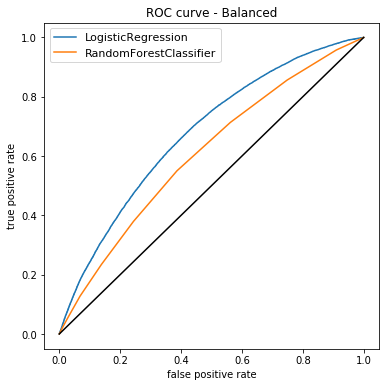

In [293]:
index_split = int(len(X)/2)#split index in by length of X/2
X_train, y_train = SMOTE().fit_sample(X_scaled[0:index_split, :], y[0:index_split])
#use SMOTE to fit sample
#Define X parameter to fit to and Y
#new training data set
X_test, y_test = X_scaled[index_split:], y[index_split:]
#define test data

#scores = cross_val_score(clf, X_scaled, y , cv=5, scoring='roc_auc')

models_report_bal, conf_matrix_bal = run_models(X_train, y_train, X_test, y_test, model_type = 'Balanced')
#same as before, but change model type to balanced now
#The “balanced” mode uses the values of y to automatically adjust weights 
#inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))

In [294]:
models_report_bal #balanced report

,model,matthews_corrcoef,roc_auc_score,precision_score,recall_score,f1_score,model_type
0,LogisticRegression,0.183868,0.676755,0.217765,0.655214,0.326887,Balanced
1,RandomForestClassifier,0.093805,0.607686,0.221664,0.234221,0.227770,Balanced


In [295]:
conf_matrix_bal['LogisticRegression'] #balanced logistic regression

Predicted,0,1
True,,
0,73873,48364
1,7085,13464


In [296]:
conf_matrix_bal['RandomForestClassifier'] #balanced logistic regression

Predicted,0,1
True,,
0,105337,16900
1,15736,4813
